# dependencies

In [2]:
import pandas as pd

C:\Users\aryan\AppData\Local\Temp\ipykernel_28052\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# creating df

In [3]:
df = pd.read_csv("cyberpunk_2077_filtered.csv")
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612380 entries, 0 to 612379
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   language            612380 non-null  object
 1   review              612380 non-null  object
 2   updated             612380 non-null  object
 3   voted_up            612380 non-null  bool  
 4   votes_up            612380 non-null  int64 
 5   votes_funny         612380 non-null  int64 
 6   steam_purchase      612380 non-null  bool  
 7   playtime_at_review  612380 non-null  int64 
dtypes: bool(2), int64(3), object(3)
memory usage: 29.2+ MB


# parsing data

In [5]:
# converting the "updated" column to datetime

df["updated"] = pd.to_datetime(df["updated"])
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


# data exploration

In [6]:
print(df["updated"].min())
print(df["updated"].max())

2020-12-10 00:00:00
2023-12-13 00:00:00


In [7]:
upvote_rate = df.groupby([df['updated'].dt.year, df['updated'].dt.month])["voted_up"].mean()
upvote_rate

updated  updated
2020     12         0.796547
2021     1          0.759931
         2          0.697995
         3          0.604137
         4          0.679466
         5          0.664692
         6          0.644182
         7          0.693751
         8          0.668697
         9          0.725406
         10         0.727986
         11         0.837535
         12         0.725762
2022     1          0.769399
         2          0.766254
         3          0.729357
         4          0.809488
         5          0.833111
         6          0.800058
         7          0.821162
         8          0.841162
         9          0.865291
         10         0.885975
         11         0.921670
         12         0.888151
2023     1          0.845213
         2          0.847692
         3          0.871475
         4          0.801884
         5          0.861364
         6          0.796880
         7          0.870963
         8          0.875830
         9          0.8464

<Axes: xlabel='updated,updated'>

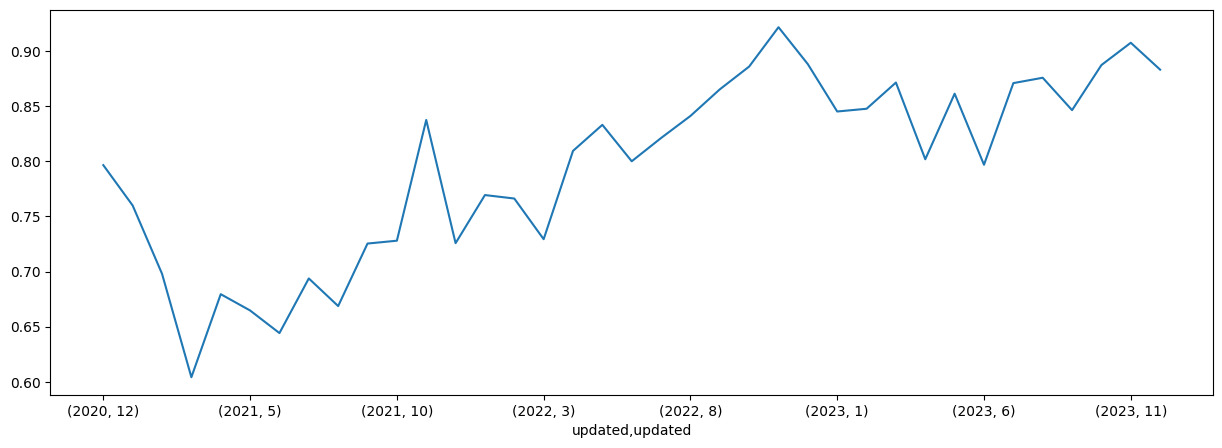

In [8]:
upvote_rate.plot(kind="line", figsize=(15, 5))

In [9]:
df["playtime_at_review"].max()

831446

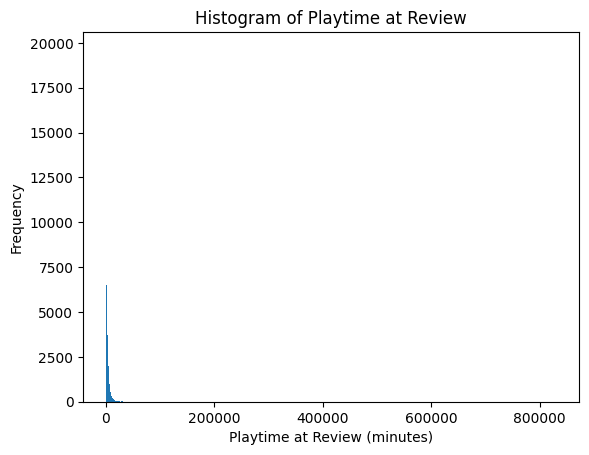

In [10]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(df['playtime_at_review'], bins=int(df['playtime_at_review'].max() / 60))

# Add labels and title
plt.xlabel('Playtime at Review (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Playtime at Review')

# Show the histogram
plt.show()


C:\Users\aryan\AppData\Local\Temp\ipykernel_28052\2548741421.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_playtime_group = df.groupby(play_time_series)['voted_up'].mean()


<Axes: xlabel='playtime_at_review'>

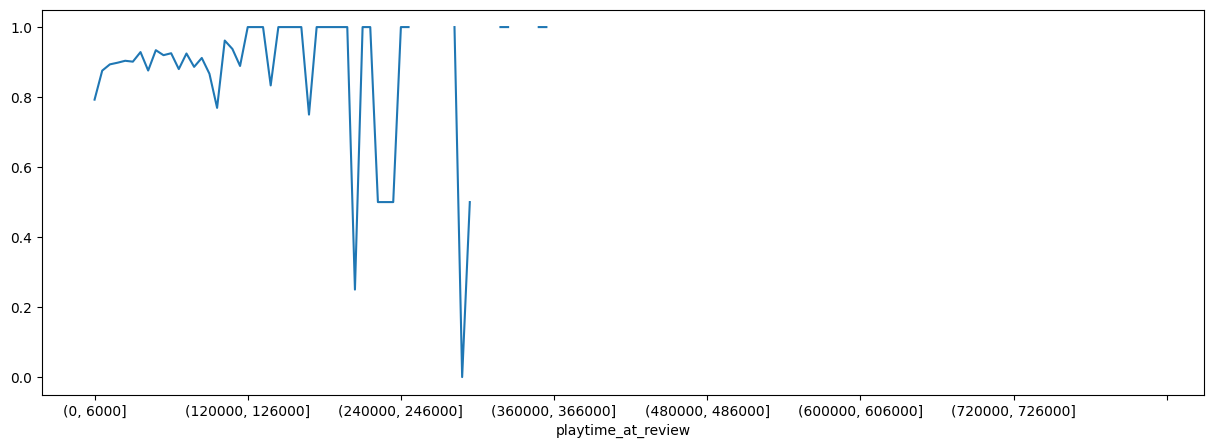

In [11]:
# Define the bin edges
bin_edges = range(0, int(df['playtime_at_review'].max()) + 6001, 6000)

# Group the data by playtime intervals
play_time_series = pd.cut(df['playtime_at_review'], bins=bin_edges)

df_playtime_group = df.groupby(play_time_series)['voted_up'].mean()
# Count the number of reviews in each playtime group
df_playtime_group.plot(kind='line', figsize=(15, 5))


# hypothesis1: the longer the playtime, the more likely the review is positive

# hypothesis 2: English speaking people are salty (less voted_up rate)

# hypothesis 3: ascii art = more upvotes

In [40]:
spoilers = df[df['review'].str.contains('[spoiler]', case=False) & df['review'].str.contains('⣿', case=False)]

In [50]:
def filter_characters(review):
    return ''.join(c for c in review if ('\u2800' <= c <= '\u28FF' or c == '\n' or c == ' '))

spoilers['review'] = spoilers['review'].apply(filter_characters)
spoilers['review'] = spoilers['review'].apply(lambda x: x.strip())

spoilers.drop_duplicates(subset='review', keep=False, inplace=True)

for i in range(447):
    print(spoilers.iloc[i]['review'])
    print()

⠄⣿⣿⣿⣿⠘⡿⢛⣿⣿⣿⣿⣿⣧⢻⣿⣿⠃⠸⣿⣿⣿⠄⠄⠄⠄⠄
⠄⠄⣿⣿⣿⣿⢀⠼⣛⣛⣭⢭⣟⣛⣛⣛⠿⠿⢆⡠⢿⣿⣿⠄⠄⠄⠄⠄
⠄⠄⠸⣿⣿⢣⢶⣟⣿⣖⣿⣷⣻⣮⡿⣽⣿⣻⣖⣶⣤⣭⡉⠄⠄⠄⠄⠄
⠄⠄⠄⢹⠣⣛⣣⣭⣭⣭⣁⡛⠻⢽⣿⣿⣿⣿⢻⣿⣿⣿⣽⡧⡄⠄⠄⠄
⠄⠄⠄⠄⣼⣿⣿⣿⣿⣿⣿⣿⣿⣶⣌⡛⢿⣽⢘⣿⣷⣿⡻⠏⣛⣀⠄⠄
⠄⠄⠄⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⠙⡅⣿⠚⣡⣴⣿⣿⣿⡆⠄
⠄⠄⣰⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⠄⣱⣾⣿⣿⣿⣿⣿⣿⠄
⠄⢀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠄
⠄⣸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠣⣿⣿⣿⣿⣿⣿⣿⣿⣿⠄
⠄⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠛⠑⣿⣮⣝⣛⠿⠿⣿⣿⣿⣿⠄
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⠄⠄⠄⠄⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⠄

⠀⠀⠀⠀⠀⠀⠀⢀⣠⣤⣶⣶⣶⣶⣶⣤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⣠⣴⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣶⣄⡀⠀⠀⠀⠀⠀
⠀⠀⠀⣠⣴⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣮⣵⣄⠀⠀⠀
⠀⠀⢾⣻⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⡀⠀
⠀⠸⣽⣻⠃⣿⡿⠋⣉⠛⣿⣿⣿⣿⣿⣿⣿⣿⣏⡟⠉⡉⢻⣿⡌⣿⣳⡥⠀
⠀⢜⣳⡟⢸⣿⣷⣄⣠⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⣤⣠⣼⣿⣇⢸⢧⢣⠀
⠀⠨⢳⠇⣸⣿⣿⢿⣿⣿⣿⣿⡿⠿⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⠀⡟⢆⠀
⠀⠀⠈⠀⣾⣿⣿⣼⣿⣿⣿⣿⡀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣽⣿⣿⠐⠈⠀⠀
⠀⢀⣀⣼⣷⣭⣛⣯⡝⠿⢿⣛⣋⣤⣤⣀⣉⣛⣻⡿⢟⣵⣟⣯⣶⣿⣄⡀⠀
⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣶⣶⣾⣶⣶⣴⣾⣿⣿⣿⣿⣿⣿⢿⣿⣿⣧
⣿⣿⣿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⠿⣿⡿

⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣤⣴⣶⡶⣶⣶⣦⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⡾⠛⠉⢠⣶⣿⣿⣶⣄⠉⠛⢿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣿⠋⠀⠀⠀⣿⣿⣿⣿⣿⣿⠀⠀⠀⠙⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣿⢣⣴⣶⣶⣦⡹⢿⣿⣿⡿⢏⣴⣶⣶⣦⡜⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⡏⣿⣿⣿⣿⣿⣿⠀⣿⡿⠀⣿⣿⣿⣿⣿⣿⢸⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⡇⠻⣿⣿⣿⣿⣿⡀⣽⣿⢀⣽⣿⣿⣿⣿⠟⢸⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣿⡀⠈⠉⠉⠉⠻⣿⣿⣿⣾⠟⠁⠉⠉⠁⠀⣾⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣷⡀⠀⠀⠀⠀⠈⣿

C:\Users\aryan\AppData\Local\Temp\ipykernel_28052\3874534137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spoilers['review'] = spoilers['review'].apply(filter_characters)
C:\Users\aryan\AppData\Local\Temp\ipykernel_28052\3874534137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spoilers['review'] = spoilers['review'].apply(lambda x: x.strip())
C:\Users\aryan\AppData\Local\Temp\ipykernel_28052\3874534137.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr